# Road Segmentation using U-Net and PyTorch

segmentation_models_pytorch documentation: https://smp.readthedocs.io/en/latest/

This notebook demonstrates a complete workflow for a road segmentation task using a U-Net-based model. We will be using a subset of the Massachusetts Roads Dataset.
# 
The primary goal is to train a model that can accurately identify and segment roads from high-resolution aerial images.
# 

## Project Workflow
# 
 1.  **Setup**: Import necessary libraries and configure the environment.
2.  **Configuration**: Define key parameters and hyperparameters.
3.  **Data Loading & Exploration**: Load data and visualize samples.
4.  **Data Augmentation & Custom Dataset**: Define augmentations and create a PyTorch Dataset.
5.  **DataLoaders**: Prepare data loaders for batching.
6.  **Model Architecture**: Define the U-Net segmentation model.
7.  **Training**: Implement the training and validation loops and train the model.
8.  **Inference & Visualization**: Perform inference and save the results.
#

### 1. Setup and Imports
# 
This section consolidates all necessary library imports. We also clone the dataset repository if it's not already present.

It is recommended to run these installations in your terminal using a requirements.txt file
```
!pip install segmentation-models-pytorch albumentations opencv-contrib-python pandas scikit-learn matplotlib tqdm
```

In [1]:
# --- Core Libraries ---
import os
import sys

# --- Data Handling and Numerical Operations ---
import numpy as np
import pandas as pd
import cv2 # OpenCV

# --- Machine Learning and Deep Learning (PyTorch) ---
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# --- Data Preprocessing ---
from sklearn.model_selection import train_test_split

# --- Image Augmentation ---
import albumentations as A

# --- Visualization ---
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Custom Helper Functions ---
# Uncomment the following lines if the repository is not in the current directory
# !git clone https://github.com/parth1620/Road_seg_dataset.git
# sys.path.append('./Road_seg_dataset')
from Road_seg_dataset import helper

/opt/anaconda3/envs/visualization/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Environment Configuration
# 
We'll check for the availability of a GPU (CUDA or Apple's MPS) and set the device accordingly. If no GPU is found, the script will default to the CPU.

In [2]:
# %%
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple's MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple's MPS


### 3. Configuration and Hyperparameters
# 
All key parameters for the project are defined in this section for easy modification and tracking.


In [3]:
CSV_FILE = './Road_seg_dataset/train.csv'
DATA_DIR = './Road_seg_dataset/'

EPOCHS = 15
LEARNING_RATE = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

# Model configuration using a pre-trained EfficientNet-B0 encoder
ENCODER = 'timm-efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'

### 4. Data Loading and Exploration
# 
We load the dataset metadata from the CSV and visualize a sample image and its corresponding mask to understand the data format.


In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


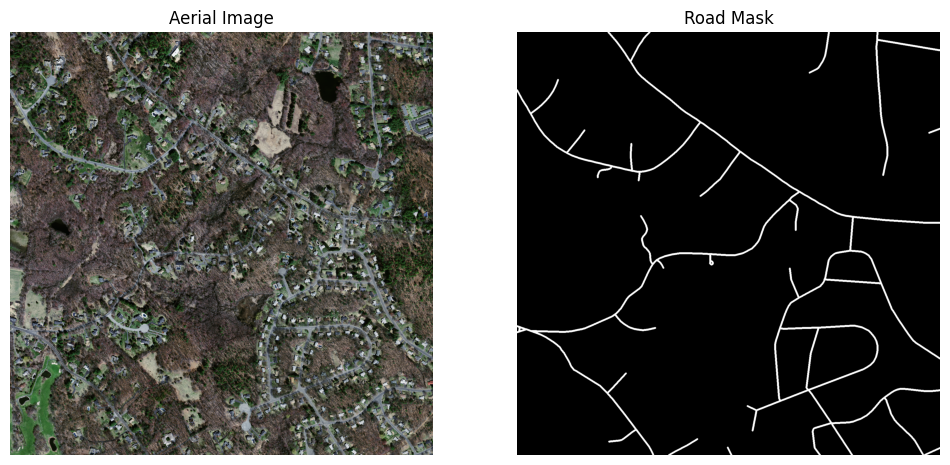

Size of Training Set: 159
Size of Validation Set: 40


In [5]:
# Select an index to display a sample
idx = 20
row = df.iloc[idx]

# Construct full paths and read the image and mask
image_path = os.path.join(DATA_DIR, row.images)
mask_path = os.path.join(DATA_DIR, row.masks)
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

# Plot the image and mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title('Aerial Image')
ax1.imshow(image)
ax1.axis('off')
ax2.set_title('Road Mask')
ax2.imshow(mask, cmap='gray')
ax2.axis('off')
plt.show()

# %%
# Split the dataframe into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Size of Training Set: {len(train_df)}")
print(f"Size of Validation Set: {len(valid_df)}")

### 5. Data Augmentation & Custom Dataset
# 
We define augmentation pipelines and create a custom PyTorch `Dataset` class to handle loading, augmenting, and formatting the data.


Size of instantiated training set: 159
Size of instantiated validation set: 40


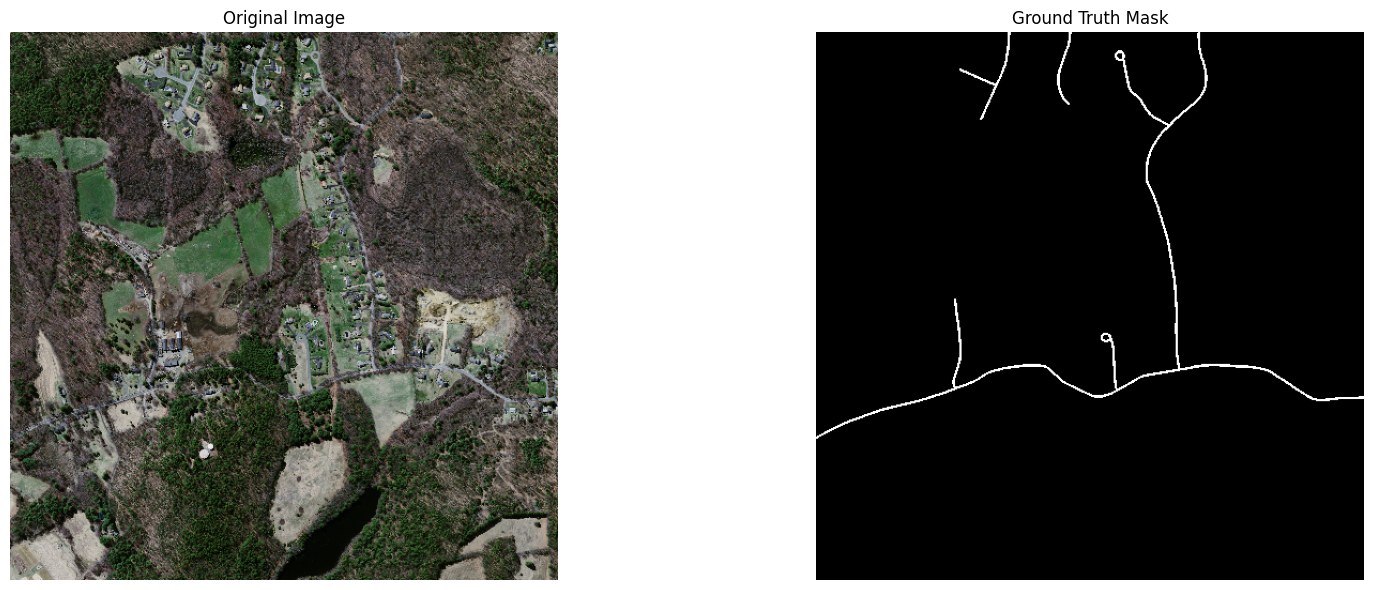

In [6]:
def get_train_augs():
    """Defines the augmentation pipeline for the training set."""
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

def get_valid_augs():
    """Defines the augmentation pipeline for the validation set (only resizing)."""
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ])

class RoadSegmentationDataset(Dataset):
    def __init__(self, dataframe, augmentations):
        self.dataframe = dataframe
        self.augmentation = augmentations

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(DATA_DIR, row.images)
        mask_path = os.path.join(DATA_DIR, row.masks)

        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Transpose to (C, H, W) format required by PyTorch and normalize
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        
        image = torch.tensor(image) / 255.0
        mask = torch.round(torch.tensor(mask) / 255.0)

        return image, mask
    
    # %%
# Create dataset instances
trainset = RoadSegmentationDataset(train_df, get_train_augs())
validset = RoadSegmentationDataset(valid_df, get_valid_augs())
print(f'Size of instantiated training set: {len(trainset)}')
print(f'Size of instantiated validation set: {len(validset)}')

# %%
# Visualize a sample from the training set to verify augmentations
idx = 3
image, mask = trainset[idx]
helper.show_image(image, mask)

### 6. DataLoaders
# 
`DataLoader`s are created to batch and shuffle the data, which is essential for efficient model training.


In [7]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total no. of batches in trainloader: {len(trainloader)}')
print(f'Total no. of batches in validloader: {len(validloader)}')

# Check the shape of a single batch
for images, masks in trainloader:
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Shape of one batch of masks: {masks.shape}")
    break

Total no. of batches in trainloader: 20
Total no. of batches in validloader: 5
Shape of one batch of images: torch.Size([8, 3, 512, 512])
Shape of one batch of masks: torch.Size([8, 1, 512, 512])


### 7. Model Architecture
# 
We define the U-Net model using the `segmentation-models-pytorch` library. The loss function is a combination of Dice Loss and BCEWithLogitsLoss.

In [8]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)
        if masks is not None:
            loss = DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss
        return logits

model = SegmentationModel()
model.to(device)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): S

### 8. Training the Model
# 
Here we define the training and validation functions and execute the main training loop, saving the model with the best validation loss.


In [9]:
def train_fn(data_loader, model, optimizer):
    """Function for a single training epoch."""
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(data_loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        _, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    """Function for a single validation epoch."""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            _, loss = model(images, masks)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# %%
# Define the optimizer and start the training loop
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
best_valid_loss = float('inf')

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ MODEL SAVED!")
        best_valid_loss = valid_loss
        
    print(f"Epoch {i+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


✅ MODEL SAVED!
Epoch 1/15, Train Loss: 1.0993, Valid Loss: 1.0972


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


✅ MODEL SAVED!
Epoch 2/15, Train Loss: 0.7898, Valid Loss: 0.9405


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


✅ MODEL SAVED!
Epoch 3/15, Train Loss: 0.7103, Valid Loss: 0.8173


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


✅ MODEL SAVED!
Epoch 4/15, Train Loss: 0.6925, Valid Loss: 0.7635


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


✅ MODEL SAVED!
Epoch 5/15, Train Loss: 0.6657, Valid Loss: 0.7549


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


✅ MODEL SAVED!
Epoch 6/15, Train Loss: 0.6571, Valid Loss: 0.7300


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


✅ MODEL SAVED!
Epoch 7/15, Train Loss: 0.6485, Valid Loss: 0.6703


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 8/15, Train Loss: 0.6272, Valid Loss: 0.7163


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 9/15, Train Loss: 0.6279, Valid Loss: 0.7501


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 10/15, Train Loss: 0.6451, Valid Loss: 0.6844


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 11/15, Train Loss: 0.6210, Valid Loss: 0.6709


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 12/15, Train Loss: 0.6120, Valid Loss: 0.6751


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


✅ MODEL SAVED!
Epoch 13/15, Train Loss: 0.6043, Valid Loss: 0.6637


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


✅ MODEL SAVED!
Epoch 14/15, Train Loss: 0.5956, Valid Loss: 0.6234


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

Epoch 15/15, Train Loss: 0.5967, Valid Loss: 0.6407


# ### 9. Inference and Saving Results
# 
Finally, we load the best model, perform inference on a sample from the validation set, and visualize and save the final comparison image.


✅ Figure saved to: prediction_result.png


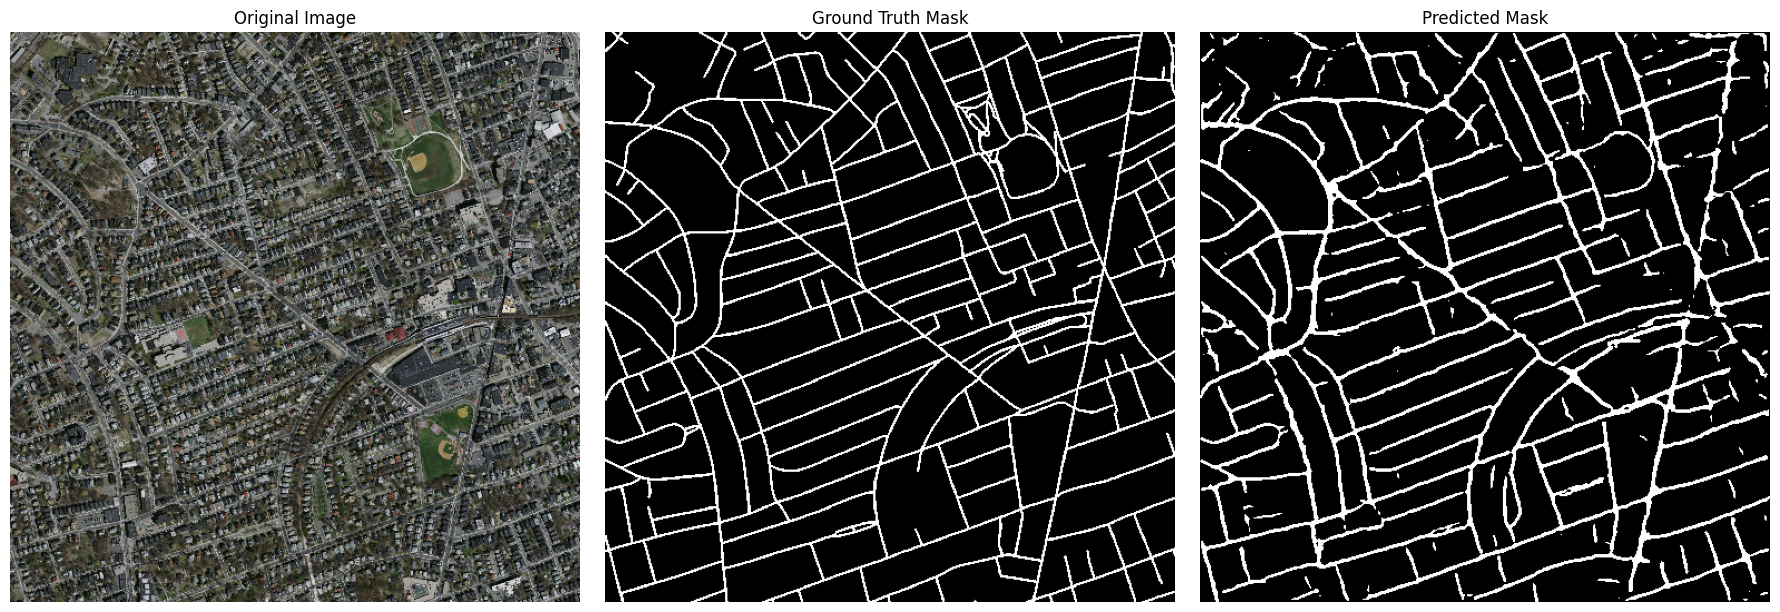

In [10]:
# %%
# Load the best saved model weights
model.load_state_dict(torch.load('best_model.pth'))

# Select a sample from the validation set
idx = 30
image, mask = validset[idx]

# Perform inference
logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

# Define a path to save the output image
output_filename = 'prediction_result.png'

# Visualize and save the result using the helper function
helper.show_image(
    image, 
    mask, 
    pred_mask.detach().cpu().squeeze(0), 
    save_path=output_filename
)